In [7]:
import torch
import matplotlib.pyplot as plt
import ESN
import time
import numpy as np
torch.set_default_device("cuda:0")
torch.set_default_dtype(torch.double)
# Parameters
Two,Ttrain = 2000,10000
sigma = 0.1
N = 50
C = 0.9
rho=0.6
dim = 1
actf="identity" 
actf="tanh"
actf="leakyReLU"


N_d = int(N * dim)
maxtau = int(N * 2)
taus = np.arange(1,maxtau)

#colors = ["r", "g", "b", "c", "m", "y","pink","lime"]
torch.manual_seed(0)
#torch.manual_seed(11)

u_asym = torch.rand(dim, Two + Ttrain)
#u_sym = u_asym
u_sym = 2 * u_asym - 1

#esn = ESN.ESN_mult(N_d, uC=C, dim=dim,sigma=sigma)
esn = ESN.ESN_mult(N_d, rho=rho, dim=dim,sigma=sigma)

st = time.time()
Xwo = esn.run_washout(u_sym, Two, actf=actf)
print("runtime :",time.time()-st)


""" 
##Memory Capacity
st = time.time()
mfs, mc_sur = ESN.MC_cSVD(u_sym, Xwo,maxtau=maxtau,ret_sur=True)
print("mc:",time.time()-st)
print("surrogate:",mc_sur)
"""


runtime : 0.7180182933807373


' \n##Memory Capacity\nst = time.time()\nmfs, mc_sur = ESN.MC_cSVD(u_sym, Xwo,maxtau=maxtau,ret_sur=True)\nprint("mc:",time.time()-st)\nprint("surrogate:",mc_sur)\n'

In [8]:
W=esn.get_W()
u,s,vh=torch.linalg.svd(W)
print(s)

tensor([0.9867, 0.9717, 0.9611, 0.9360, 0.9286, 0.8674, 0.8352, 0.8025, 0.7886,
        0.7653, 0.7529, 0.7190, 0.6864, 0.6773, 0.6647, 0.6532, 0.6370, 0.6079,
        0.5938, 0.5558, 0.5375, 0.5127, 0.5039, 0.4834, 0.4696, 0.4465, 0.4314,
        0.4062, 0.3920, 0.3636, 0.3322, 0.3108, 0.3073, 0.2831, 0.2650, 0.2532,
        0.2370, 0.2193, 0.2025, 0.1810, 0.1643, 0.1525, 0.1482, 0.1111, 0.0956,
        0.0830, 0.0689, 0.0600, 0.0406, 0.0155], device='cuda:0')


In [9]:
maxdd=[[1,50],[2,30],[3,20],[4,10],[5,15]]
st = time.time()
tar_info = ESN.make_targets(u_sym,maxdd,Two=Two)
print("target :",time.time()-st)



basis table creation:0.003 s
1 degree:50 target functions
2 degree:465 target functions
3 degree:1540 target functions
4 degree:715 target functions
5 degree:11628 target functions
target : 17.63648295402527


In [10]:
st = time.time()
raw,lin,thr,rev,sur = ESN.calc_capacity(Xwo,tar_info.tar_f,sur_sets=200,ret_all=True,thr_scale=1.2)
print("ipc :",time.time()-st)
capacities = rev
"""
ipc_thr=torch.sum(thr).cpu().numpy()
ipc_rev=torch.sum(rev).cpu().numpy()
ipc_raw=torch.sum(raw).cpu().numpy()
print("raw",ipc_raw)
print("rev",ipc_rev)
print("thr",ipc_thr)
"""

ipc : 3.8628222942352295


'\nipc_thr=torch.sum(thr).cpu().numpy()\nipc_rev=torch.sum(rev).cpu().numpy()\nipc_raw=torch.sum(raw).cpu().numpy()\nprint("raw",ipc_raw)\nprint("rev",ipc_rev)\nprint("thr",ipc_thr)\n'

In [11]:
capacities=thr
dgrs = torch.tensor(tar_info.degree)
c_1st=torch.sum(capacities[torch.argwhere(dgrs==1)])
c_2nd=torch.sum(capacities[torch.argwhere(dgrs==2)])
c_3rd=torch.sum(capacities[torch.argwhere(dgrs==3)])
c_4th=torch.sum(capacities[torch.argwhere(dgrs==4)])
c_5th=torch.sum(capacities[torch.argwhere(dgrs==5)])
print("1st order ipc:",float(c_1st))
print("2nd order ipc:",float(c_2nd))
print("3rd order ipc:",float(c_3rd))
print("4th order ipc:",float(c_4th))
print("5th order ipc:",float(c_5th))


1st order ipc: 15.054984414877278
2nd order ipc: 0.0
3rd order ipc: 35.48062387634957
4th order ipc: 0.025964768835927785
5th order ipc: 1.7381023681011725


In [50]:

ipc = ESN.IPC_w_targetinfo(capacities=rev,target_info=tar_info)

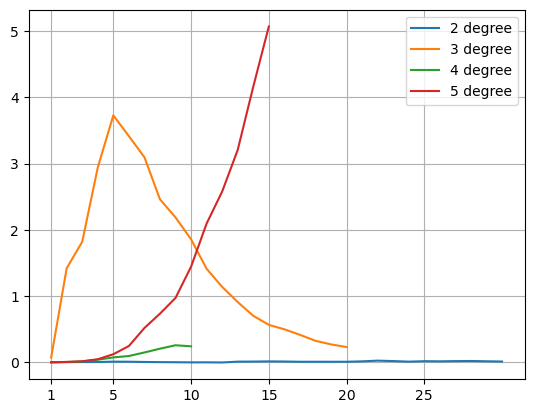

In [51]:
ipc_tau_sum = ESN.ipc_tau(ipc=ipc,mode="sum")
degrees = range(len(ipc_tau_sum))
degrees = [1,2,3,4]
#degrees = [1,3,4]

for deg in degrees:
    plt.plot(np.arange(1,ipc_tau_sum[deg].shape[0]+1),ipc_tau_sum[deg].cpu().numpy(),label=f"{deg+1} degree")
    
    

plt.legend()
plt.xticks([1]+list(np.arange(5,30,5)))
plt.grid()
plt.show()

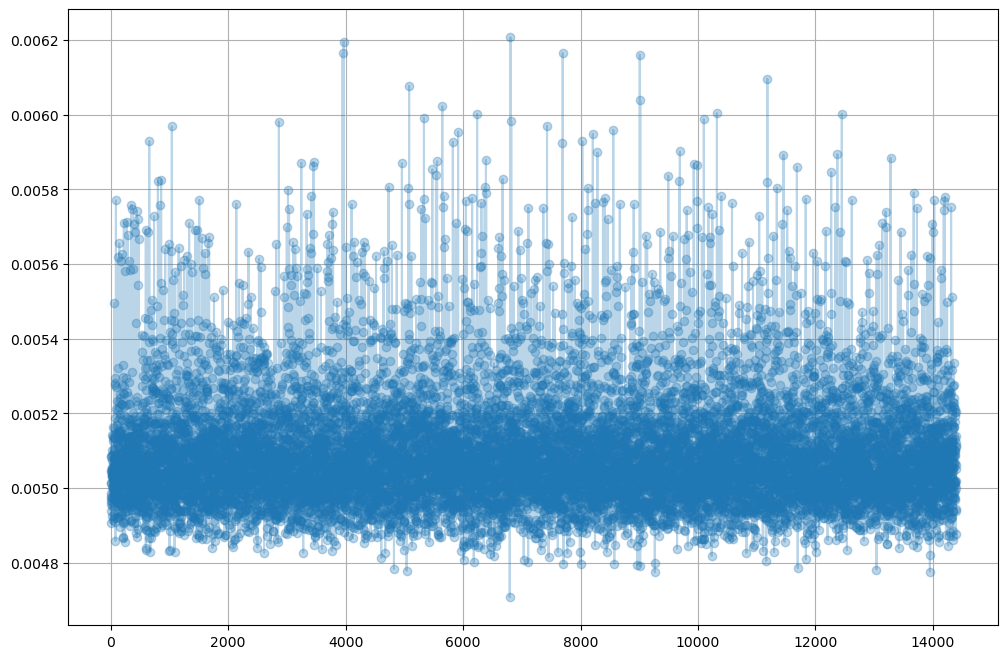

In [36]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(np.arange(sur.shape[0]),sur.cpu().numpy(),"-o",alpha=0.3)
#plt.hlines(y=mc_sur.cpu().numpy(),xmax=0,xmin=sur.shape[0],color="red")
plt.grid(True)


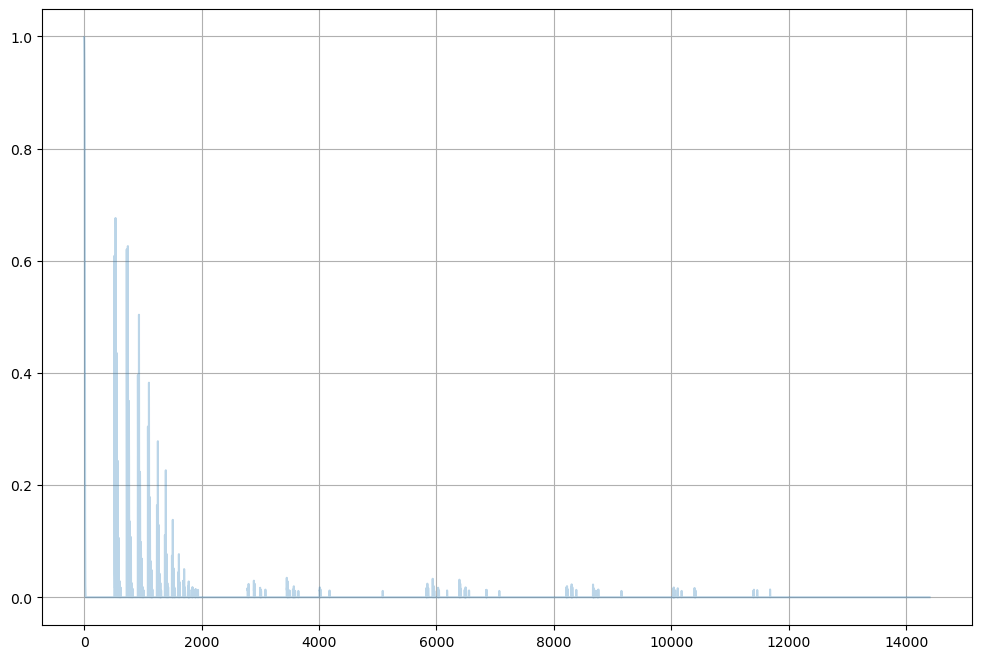

In [40]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(np.arange(sur.shape[0]),thr.cpu().numpy(),"-",alpha=0.3)
plt.grid(True)

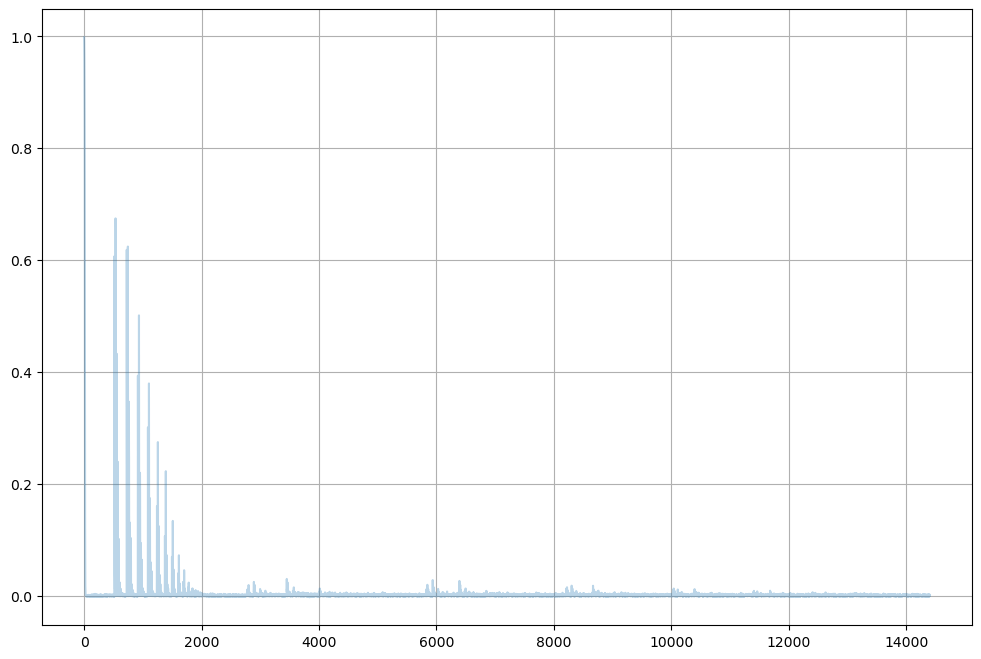

In [41]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(np.arange(sur.shape[0]),rev.cpu().numpy(),"-",alpha=0.3)
plt.grid(True)